# Exploratory Data Analysis of Palladium Spot Price

Data is provided free for non-commercial use by Perth Mint (www.perthmint.com)

## The Task

Extract-Load-Transform (ELT) process of transforming noisy data in CSV files (e.g. inconsistent data types, spurious values, etc.) into cleaned data suitable for increasingly sophisticated analysis.

In [1]:
import locale
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.parser import parse

This function ensures Pandas will not throw a huge number of exceptions without good reason.

In [2]:
def locale_string_to_float(value):
    """On a best efforts basis converts the string argument into a floating point number"""
    returnVal = np.nan
    try:
        returnVal = locale.atof(value)
    except ValueError as error:
        pass
    
    return returnVal

A specific problem with the CSV files occurs when dates cross from the 10th to the 11th of some months.

In [3]:
def clean_data(filename):
    """Keeping the original file named in the argument, creates a new CSV file with contiguous ISO-correct dates"""
    with open(filename, 'r') as in_file:
        old_date = datetime(1900, 1, 1)
        with open(filename + '.cleaned.csv', 'w') as out_file:
            for line in in_file:
                if re.match('^"?\d+', line):
                    data_list = line.split(',')
            
                    matched = re.search('^"?(\d+)/(\d+)/(\d+)"?\s*$',
                                        data_list[0])
                    year_string = matched[3]
                    maybe_month_string = matched[2]
                    maybe_day_string = matched[1]
                    current_date = parse('{}/{}/{}'.format(
                        maybe_day_string, maybe_month_string, year_string))
                    if abs((current_date - old_date).days) > 1:
                        current_date = parse('{}/{}/{}'.format(
                        maybe_month_string, maybe_day_string, year_string))
                    print('{},{}'.format(current_date,','.join(data_list[1:])), 
                          end='', file=out_file)
                    old_date = current_date

A function to remove outliers in a given pandas dataframe. The valid column name is given as well as a floating point threshold factor. All rows with values too far above or below the threshold are returned as a list.

In [4]:
def abnormal_value_indices(df, column_name, threshold_factor):
    """Given a valid dataframe, a column in it and a threshold, returns rows that exceed the threshold"""
    abnormals_list = []
    previous_value = df[column_name][0]
    for i in range(1, len(df[column_name])):
        current_value = df[column_name][i]
        if (previous_value > current_value * threshold_factor) or (current_value > previous_value * threshold_factor):
            abnormals_list.append(df.index[i])
        else:
            previous_value = current_value
    print(abnormals_list)
    return(abnormals_list)

Create CSV files filled with clean (albeit sparse) data based on the original CSV files.

In [5]:
clean_data(r'Data\part_1.csv')

In [6]:
clean_data(r'Data\part_2.csv')

Data is split between the 2 CSV files. There are prices from 1968 to 2015 in one, and from 2016 onwards in the other.

In [7]:
df_london_fixes_daily_1968_2015 = pd.read_csv(
    r'Data\part_1.csv.cleaned.csv', 
    header=None,
    names=['Date', 'Au AM', 'Au PM', 'Ag', 'Pt AM', 'Pt PM', 'Pd AM', 'Pd PM'],
    index_col=0, 
    skiprows=[0,1,2,3,4],
    usecols=[0,1,2,3,4,5,6,7],
    parse_dates=True,
    converters={1: locale_string_to_float,
                2: locale_string_to_float,
                3: locale_string_to_float,
                4: locale_string_to_float,
                5: locale_string_to_float,
                6: locale_string_to_float,
                7: locale_string_to_float})

The dataframe deliberately holds NaN values as compaction will be done just before the data is needed.

In [8]:
df_london_fixes_daily_1968_2015.head()

,Au AM,Au PM,Ag,Pt AM,Pt PM,Pd AM,Pd PM
Date,,,,,,,
2068-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068-01-08,35.14,NaN,2.163,NaN,NaN,NaN,NaN
2068-01-09,35.14,NaN,2.109,NaN,NaN,NaN,NaN
2068-01-10,35.15,NaN,2.085,NaN,NaN,NaN,NaN


In [9]:
df_london_fixes_daily_from_2016_on = pd.read_csv(
    r'Data\part_2.csv.cleaned.csv', 
    header=None,
    names=['Date', 'Au AM', 'Au PM', 'Ag', 'Pt AM', 'Pt PM', 'Pd AM', 'Pd PM'],
    index_col=0,
    skiprows=[0,1,2,3,4],
    usecols=[0,1,2,3,4,5,6,7],
    parse_dates=True,
    converters={1: locale_string_to_float,
                2: locale_string_to_float,
                3: locale_string_to_float,
                4: locale_string_to_float,
                5: locale_string_to_float,
                6: locale_string_to_float,
                7: locale_string_to_float})

In [10]:
df_london_fixes_daily_from_2016_on.head()

,Au AM,Au PM,Ag,Pt AM,Pt PM,Pd AM,Pd PM
Date,,,,,,,
2016-01-06,1083.85,1091.40,14.005,885.0,873.0,532.0,519.0
2016-01-07,1096.00,1106.35,14.030,869.0,865.0,496.0,486.0
2016-01-08,1097.45,1101.85,14.040,876.0,874.0,498.0,505.0
2016-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ready for basic analysis, we drop NaN entries in specific columns and then drop outliers. Here the outliers are values that are bigger or smaller than their preceding value by some factor.

In [11]:
data_d1 = {'Pd AM': df_london_fixes_daily_1968_2015['Pd AM'],
           'Pd PM': df_london_fixes_daily_1968_2015['Pd PM']}
df_palladium_1 = pd.DataFrame(data_d1).dropna(axis=0)
df_palladium_1 = df_palladium_1.drop(abnormal_value_indices(df_palladium_1, 'Pd AM', 1.5))
df_palladium_1.describe()

[Timestamp('2005-05-18 00:00:00'), Timestamp('2012-02-29 00:00:00'), Timestamp('2012-10-04 00:00:00')]


,Pd AM,Pd PM
count,6424.000000,6424.000000
mean,357.848610,357.830076
std,236.379204,236.474916
min,78.750000,78.250000
25%,154.500000,154.500000
50%,295.000000,294.000000
75%,564.000000,565.000000
max,993.000000,991.000000


In [12]:
data_d2 = {'Pd AM': df_london_fixes_daily_from_2016_on['Pd AM'],
           'Pd PM': df_london_fixes_daily_from_2016_on['Pd PM']}
df_palladium_2 = pd.DataFrame(data_d2).dropna(axis=0)
df_palladium_2 = df_palladium_2.drop(abnormal_value_indices(df_palladium_2, 'Pd AM', 1.5))
df_palladium_2.describe()

[]


,Pd AM,Pd PM
count,733.000000,733.000000
mean,827.163711,828.283083
std,183.144201,183.065234
min,465.000000,470.000000
25%,683.000000,683.000000
50%,853.000000,852.000000
75%,980.000000,982.000000
max,1192.000000,1205.000000


Combine the compacted dataframes to analyze the data contiguously from 1968 to 2016 onwards.

In [13]:
df_palladium = df_palladium_1.append(df_palladium_2)
df_palladium.describe()

,Pd AM,Pd PM
count,7157.000000,7157.000000
mean,405.914555,406.012563
std,271.722970,271.973077
min,78.750000,78.250000
25%,167.750000,166.000000
50%,330.000000,329.000000
75%,654.000000,655.000000
max,1192.000000,1205.000000


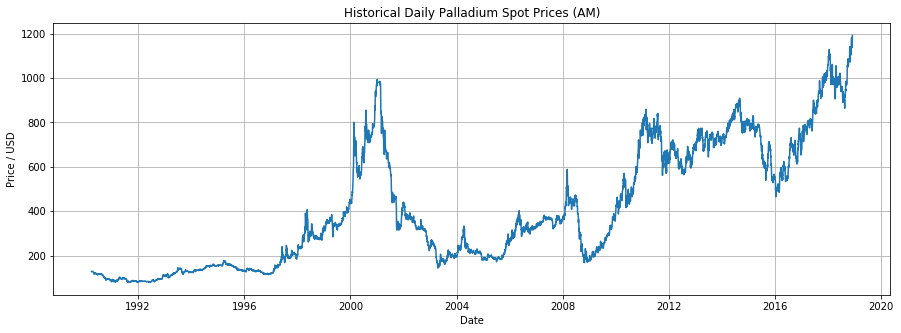

In [14]:
fig, ax = plt.subplots()
ax.plot(df_palladium['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Historical Daily Palladium Spot Prices (AM)")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

### Appendix

Visualizations to see the data transformations.

##### 1. Raw data

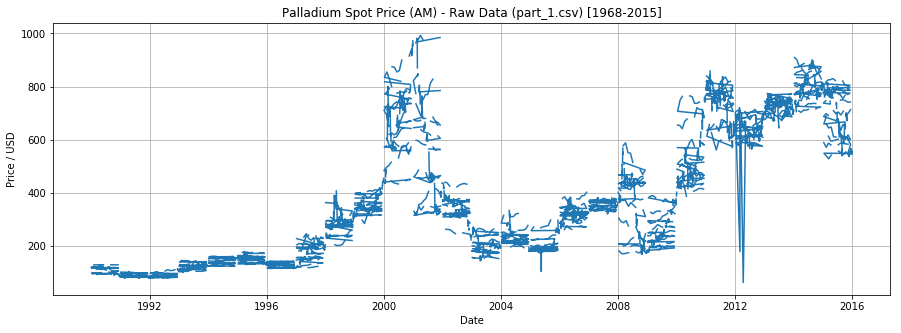

In [15]:
df_london_fixes_daily_1968_2015_raw = pd.read_csv(
    r'Data\part_1.csv', 
    header=None,
    names=['Date', 'Au AM', 'Au PM', 'Ag', 'Pt AM', 'Pt PM', 'Pd AM', 'Pd PM'],
    index_col=0, 
    skiprows=[0,1,2,3,4],
    usecols=[0,1,2,3,4,5,6,7],
    parse_dates=True,
    converters={1: locale_string_to_float,
                2: locale_string_to_float,
                3: locale_string_to_float,
                4: locale_string_to_float,
                5: locale_string_to_float,
                6: locale_string_to_float,
                7: locale_string_to_float})
fig, ax = plt.subplots()
ax.plot(df_london_fixes_daily_1968_2015_raw['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Raw Data (part_1.csv) [1968-2015]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

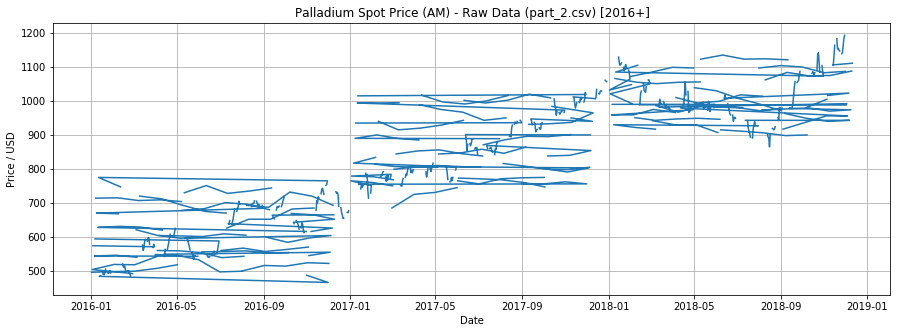

In [16]:
df_london_fixes_daily_2016_on_raw = pd.read_csv(
    r'Data\part_2.csv', 
    header=None,
    names=['Date', 'Au AM', 'Au PM', 'Ag', 'Pt AM', 'Pt PM', 'Pd AM', 'Pd PM'],
    index_col=0, 
    skiprows=[0,1,2,3,4],
    usecols=[0,1,2,3,4,5,6,7],
    parse_dates=True,
    converters={1: locale_string_to_float,
                2: locale_string_to_float,
                3: locale_string_to_float,
                4: locale_string_to_float,
                5: locale_string_to_float,
                6: locale_string_to_float,
                7: locale_string_to_float})
fig, ax = plt.subplots()
ax.plot(df_london_fixes_daily_2016_on_raw['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Raw Data (part_2.csv) [2016+]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

##### 2. Initial data cleaning 

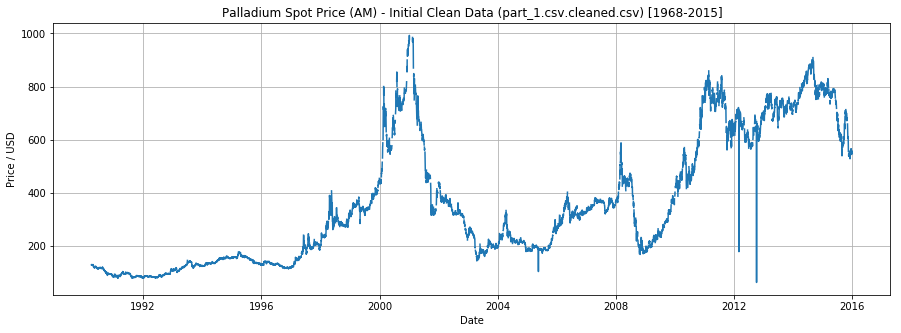

In [17]:
fig, ax = plt.subplots()
ax.plot(df_london_fixes_daily_1968_2015['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Initial Clean Data (part_1.csv.cleaned.csv) [1968-2015]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

3 extreme values are seen in the plot above: 2005-05-18, 2012-02-29, and 2012-10-04.

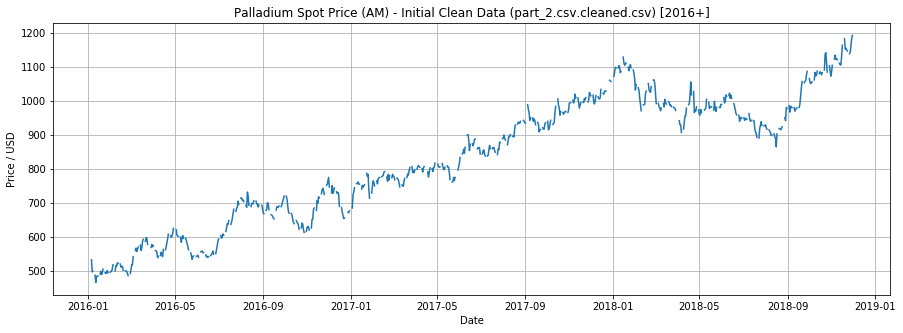

In [18]:
fig, ax = plt.subplots()
ax.plot(df_london_fixes_daily_from_2016_on['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Initial Clean Data (part_2.csv.cleaned.csv) [2016+]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

No extreme values seen in the plot above. The same data will still be run through the outlier isolation function.

##### 3. Outlier removal

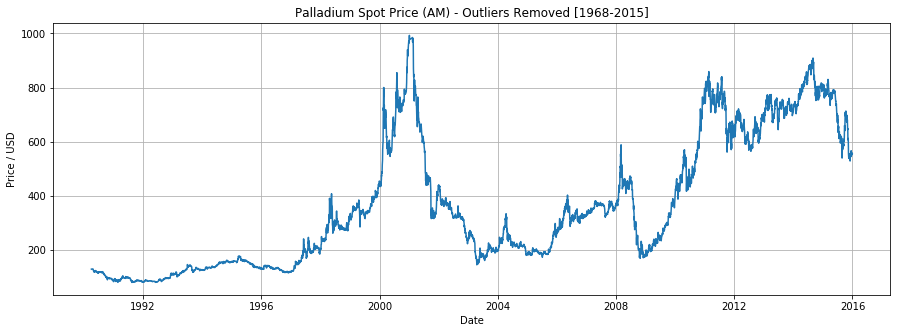

In [19]:
fig, ax = plt.subplots()
ax.plot(df_palladium_1['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Outliers Removed [1968-2015]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()

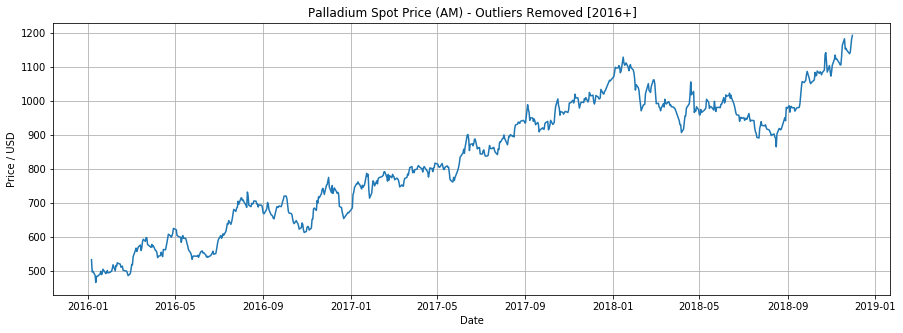

In [20]:
fig, ax = plt.subplots()
ax.plot(df_palladium_2['Pd AM'])
ax.grid()
fig.set_size_inches(15, 5)
plt.title("Palladium Spot Price (AM) - Outliers Removed [2016+]")
plt.xlabel("Date")
plt.ylabel("Price / USD")
plt.show()